ДЗ №1 «Подготовка данных»

Цель:
В ходе ДЗ студент освоит навыки сбора исходных данных и их предобработки.
Результат ДЗ - подготовленный датасет для дальнейшего построения моделей.


Описание/Пошаговая инструкция выполнения домашнего задания:
- выбрать данные для моделирования (достаточно одного источника, лучше 2)
- загрузить данные;
- прогнать стат тесты на выбросы;
- обозначить выбросы для дальнейшего анализа.

Подготовка пакетов :

In [1]:
# Загружаем используемые пакеты
#!pip install yfinance
!pip install pandas numpy matplotlib requests_cache
!pip install scikit-learn
!pip install yfinance_cache
!pip install fmp_python
!pip install outlier_utils


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.3/205.3 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: toolz
    Found existing installation: toolz 0.12.1
    Uninstalling toolz-0.12.1:
      Successfully uninstalled toolz-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 9.5.0 requires toolz<1,>=0.11, but you have toolz 1.1.0 which is incompatible.


In [2]:
import requests_cache
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
#from google.colab import drive
#drive.mount('drive')
from google.colab import files

session = requests_cache.CachedSession('yfinance.cache', expire_after=timedelta(hours=4))
session.headers['User-agent'] = 'ml-hw1-otus'

import yfinance as yf
##yf.set_config(session)

import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import shapiro, normaltest, jarque_bera, boxcox, yeojohnson
from statsmodels.stats.weightstats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)

from fmp_python.fmp import FMP





Загрузка данных:

In [3]:
# 1. Загрузка данных
ticker = ['GOOG']
start_date = '2025-01-01'
end_date = '2025-04-01'


df = yf.download(ticker, start=start_date, end=end_date, interval='1d',progress=False, multi_level_index=True)
#df.index = pd.to_datetime(df.index)
#df.columns = [df.columns[x][0] for x in range(len(df.columns))]
#df.columns = df.columns.str.lower()
#df['date'] = df.index


rdf = df['Close']
display(rdf.head())

# Рассчитываем дневную доходность (логарифмическую)
returns = np.log(rdf / rdf.shift(1)).dropna()
returns.columns = ['GOOG_Return']
display(returns.head())

# Проверка на отсутствующие значения
missing_val = returns.isna()
missing_val_sum = missing_val.sum()
display(missing_val_sum)

# Описательная статистика
display(returns.describe())


# Нормализация
#num_returns = returns['close']
#scaler = RobustScaler()
#scaler_returns = scaler.fit_transform(num_returns)

#display(scaler_returns)
#data.to_csv('data.csv')
#!cp scaler_returns.csv "/content/drive/My Drive/"
#files.download("data.csv")




/tmp/ipython-input-4148695725.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, interval='1d',progress=False, multi_level_index=True)


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2025-01-02,190.014648,192.576345,188.100848,190.866884,17545200
2025-01-03,192.506561,193.872134,190.732309,192.102870,12875000
2025-01-06,197.320969,198.915795,194.430321,194.520027,19483300
2025-01-07,196.075012,201.487476,195.307494,197.629974,16966800
2025-01-08,194.759277,197.002014,193.124572,193.323923,14335300


Ticker,GOOG
Date,
2025-01-02,190.014648
2025-01-03,192.506561
2025-01-06,197.320969
2025-01-07,196.075012
2025-01-08,194.759277


,GOOG_Return
Date,
2025-01-03,0.013029
2025-01-06,0.024701
2025-01-07,-0.006334
2025-01-08,-0.006733
2025-01-10,-0.011427


,0
GOOG_Return,0


,GOOG_Return
count,59.000000
mean,-0.003354
std,0.020878
min,-0.071900
25%,-0.013817
50%,-0.002622
75%,0.013078
max,0.030567


,GOOG_Return
Date,
2025-01-03,0.013029
2025-01-06,0.024701
2025-01-07,-0.006334
2025-01-08,-0.006733
2025-01-10,-0.011427


In [4]:
# Загрузка с FMP источника
sourcefmp = FMP(api_key='YGZt8rHN56gVgN8m0Ly0YQA7h90tAGrK', output_format='pandas', write_to_file=True)

histFmp = sourcefmp.get_historical_price('GOOG',start_date, end_date)
histFmp.columns = [histFmp.columns[x][0] for x in range(len(histFmp.columns))]
histFmp.columns = histFmp.columns.str.lower()

histFmp['d'] = pd.to_datetime(histFmp['d'])
histFmp.set_index('d', inplace=True)
histFmpClose = histFmp['c'].iloc[:,0]

returnsFmp = np.log(histFmpClose / histFmpClose.shift(1)).dropna()
display(returnsFmp.head())
display(returnsFmp.describe())

,c
d,
2025-03-31,-0.016820
2025-03-28,-0.001089
2025-03-27,0.050114
2025-03-26,0.018478
2025-03-25,0.033245


,c
count,60.000000
mean,0.003036
std,0.020903
min,-0.030567
25%,-0.013268
50%,0.002437
75%,0.013475
max,0.071899


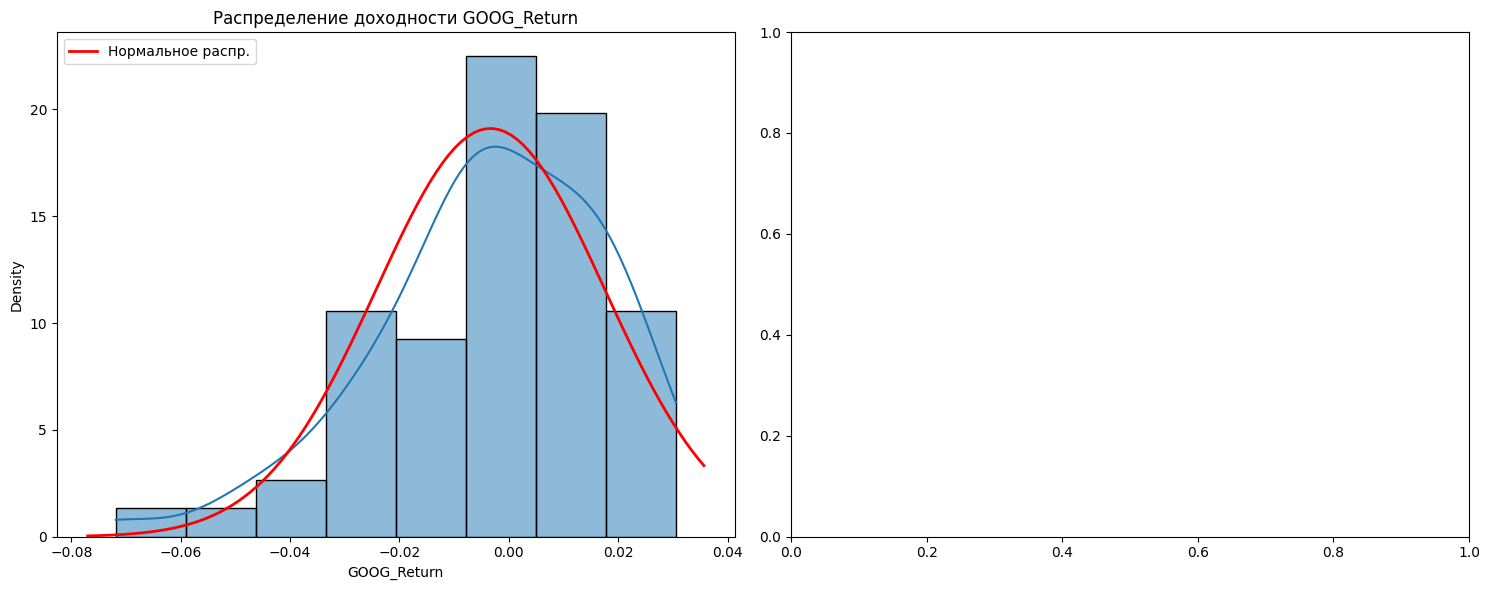

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, col in enumerate(returns.columns):
    sns.histplot(returns[col], kde=True, ax=axes[i], stat='density')
    axes[i].set_title(f'Распределение доходности {col}')
    # Добавляем линию нормального распределения с теми же параметрами
    xmin, xmax = axes[i].get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, returns[col].mean(), returns[col].std())
    axes[i].plot(x, p, 'r', linewidth=2, label='Нормальное распр.')
    axes[i].legend()

plt.tight_layout()
plt.show()

Проверка на нормальность:

In [14]:
def check_normality(data, alpha=0.05):
    """Проверяет распределение на нормальность с помощью нескольких тестов"""
    tests = {
        'Shapiro-Wilk': shapiro,
        'D\'Agostino': normaltest,
        'Jarque-Bera': jarque_bera
    }

    results = {}
    for name, test_func in tests.items():
        stat, p_value = test_func(data)
        results[name] = {'Statistic': stat, 'p-value': p_value, 'Normal': p_value > alpha}

    return pd.DataFrame(results)

print("Проверка на нормальность для GOOG:")
print(check_normality(returns['GOOG_Return']))

Проверка на нормальность для GOOG:
          Shapiro-Wilk D'Agostino Jarque-Bera
Statistic     0.954038   8.714591    8.051672
p-value       0.026024   0.012813    0.017848
Normal           False      False       False


Преобразование Бокса-Кокса:

In [18]:
# Преобразование Бокса-Кокса
# Сдвигаем доходности, чтобы сделать их положительными
from scipy.stats import boxcox_normmax, boxcox, boxcox_normplot
display(returns.head())
res = 1/1000000

small_number = 1e-6
print(float(small_number) == 0.000001)
number_lamb = 1/10000
print('{0:.4f}'.format(number_lamb))

goog_shifted = returns['GOOG_Return'] - returns['GOOG_Return'].min() + 1e-6
display(goog_shifted.head())

#https://mlgu.ru/3548/?utm_source=yandex&utm_medium=organic
#https://habr.com/ru/articles/695556/
#boxcox_func = lambda x, lmbd: (x**lmbd - 1) / lmbd if lmbd != 0 else log(x)
lmax_pearsonr_Y, lmax_mle_Y = boxcox_normmax(goog_shifted, method='all')
print(f"lmax_pearsonr_X = {lmax_pearsonr_Y}\t lmax_mle = {lmax_mle_Y}\n")
Y_boxcox = boxcox(goog_shifted, lmbda=(lmax_mle_Y))

# Применяем преобразование Бокса-Кокса
goog_boxcox = boxcox(goog_shifted, lmbda=(lmax_mle_Y))


#print(f"Оптимальные лямбда для GOOG: {lambda_aapl:.4f}")


# Проверяем нормальность после преобразования
print("\nПроверка нормальности после Бокса-Кокса для GOOG:")
print(check_normality(goog_boxcox, alpha=0.05))

,GOOG_Return
Date,
2025-01-03,0.013029
2025-01-06,0.024701
2025-01-07,-0.006334
2025-01-08,-0.006733
2025-01-10,-0.011427


True
0.0001


,GOOG_Return
Date,
2025-01-03,0.084930
2025-01-06,0.096602
2025-01-07,0.065566
2025-01-08,0.065168
2025-01-10,0.060474


lmax_pearsonr_X = 1.767575472263296	 lmax_mle = 1.0686364297981175


Проверка нормальности после Бокса-Кокса для GOOG:
          Shapiro-Wilk D'Agostino Jarque-Bera
Statistic     0.961119   6.426515    5.561828
p-value       0.056773   0.040225    0.061982
Normal            True      False        True


Преобразование Йео-Джонсона:

Оптимальные лямбда Йео-Джонсона для GOOG: 15.4054

Проверка нормальности после Йео-Джонсона для GOOG:
          Shapiro-Wilk D'Agostino Jarque-Bera
Statistic     0.987554   0.752362    0.777368
p-value       0.807985   0.686478    0.677948
Normal            True       True        True


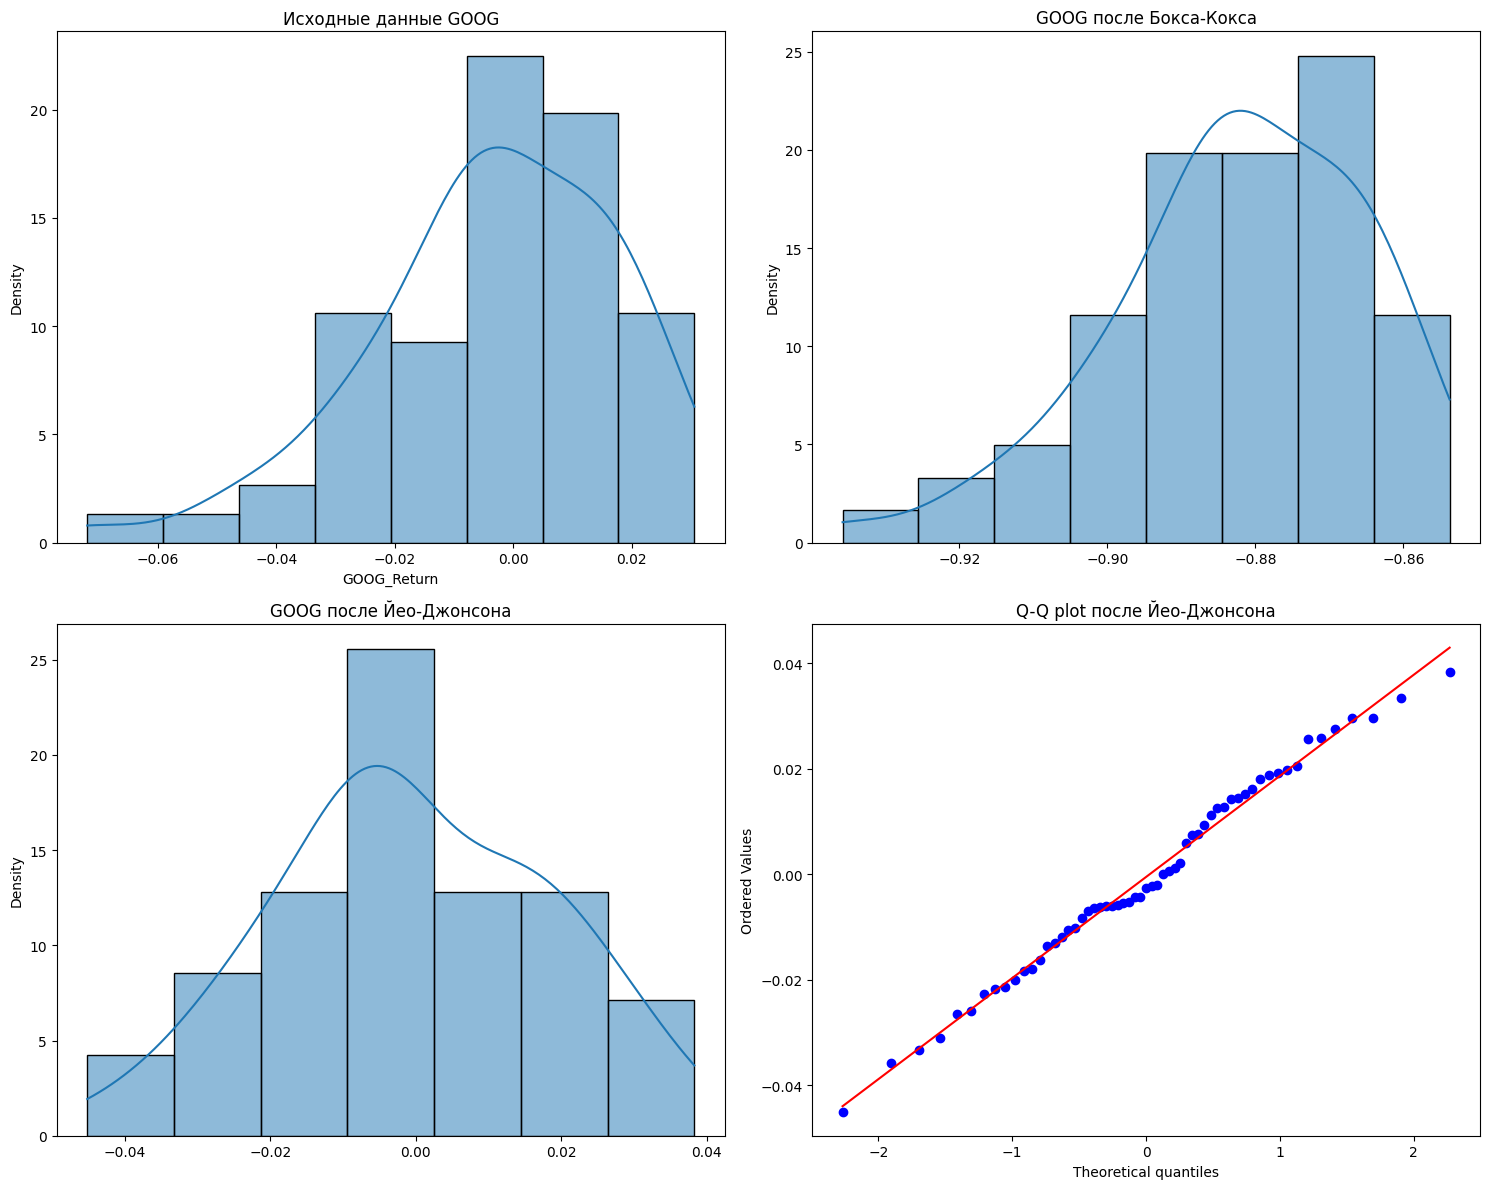

In [21]:
# Преобразование Йео-Джонсона
goog_yeojohnson, lambda_goog_yj = yeojohnson(returns['GOOG_Return'])


print(f"Оптимальные лямбда Йео-Джонсона для GOOG: {lambda_goog_yj:.4f}")


# Проверяем нормальность после преобразования
print("\nПроверка нормальности после Йео-Джонсона для GOOG:")
print(check_normality(goog_yeojohnson, alpha=0.05))

# Визуализируем преобразованные данные
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Исходные данные
sns.histplot(returns['GOOG_Return'], kde=True, ax=axes[0,0], stat='density')
axes[0,0].set_title('Исходные данные GOOG')

sns.histplot(goog_boxcox, kde=True, ax=axes[0,1], stat='density')
axes[0,1].set_title('GOOG после Бокса-Кокса')

sns.histplot(goog_yeojohnson, kde=True, ax=axes[1,0], stat='density')
axes[1,0].set_title('GOOG после Йео-Джонсона')

# Q-Q plot для проверки нормальности
stats.probplot(goog_yeojohnson, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q plot после Йео-Джонсона')

plt.tight_layout()
plt.show()

Проверка аномалий:

Выбросы GOOG: 1 наблюдений
Границы: [-0.0542, 0.0534]


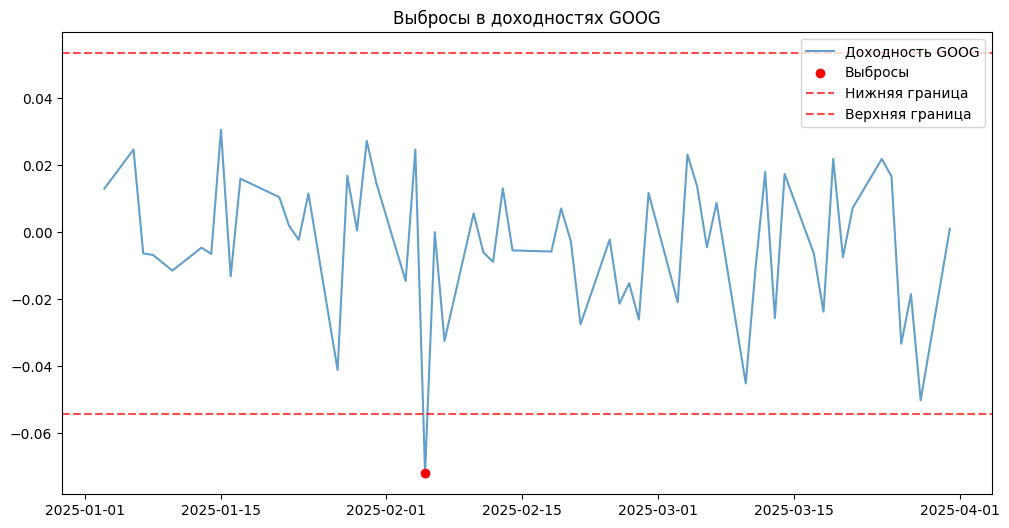

In [24]:
# Проверяем аномалии
# Метод IQR
def detect_outliers_iqr(data, column):
    """Обнаружение выбросов с помощью метода IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Детектируем выбросы для GOOG
goog_outliers, lower, upper = detect_outliers_iqr(returns, 'GOOG_Return')
print(f"Выбросы GOOG: {len(goog_outliers)} наблюдений")
print(f"Границы: [{lower:.4f}, {upper:.4f}]")

# Визуализация выбросов
plt.figure(figsize=(12, 6))
plt.plot(returns.index, returns['GOOG_Return'], label='Доходность GOOG', alpha=0.7)
plt.scatter(goog_outliers.index, goog_outliers['GOOG_Return'], color='red', label='Выбросы', zorder=5)
plt.axhline(y=lower, color='r', linestyle='--', alpha=0.7, label='Нижняя граница')
plt.axhline(y=upper, color='r', linestyle='--', alpha=0.7, label='Верхняя граница')
plt.legend()
plt.title('Выбросы в доходностях GOOG')
plt.show()


Тест Граббса на выбросы:

In [27]:
from outliers import smirnov_grubbs as grubbs

def grubbs_test_outliers(data):
    """Тест Граббса на выбросы"""
    try:
        outliers = grubbs.max_test_outliers(data, alpha=0.05)
        return outliers
    except:
        return []

# Применяем тест Граббса
goog_grubbs_outliers = grubbs_test_outliers(returns['GOOG_Return'].values)
print(f"Статистически значимые выбросы (тест Граббса): {len(goog_grubbs_outliers)}")

# Анализ дат выбросов
if len(goog_grubbs_outliers) > 0:
    outlier_dates = returns.iloc[goog_grubbs_outliers].index
    print("Даты статистически значимых выбросов:")
    for date in outlier_dates:
        print(f"  {date.date()}: {returns.loc[date, 'GOOG_Return']:.4f}")

Статистически значимые выбросы (тест Граббса): 0
